# 过程设计 

1. 读取源数据
2. 按数据表都数据段
3. 提取数据段特征
   - 原始心电图的特征（60）：频谱功率0–6 Hz（每0.1 Hz）

   - HRV特征（10）：平均值、标准差、偏度、峰度、均方根、连续差异的均方根、高于平均值+标准差的点百分比、低于平均值-标准差的点数百分比、低频频谱功率（0.01–0.08 Hz），中频谱功率（0.08–0.15 Hz）、高频谱功率（0.15–0.50 Hz）。

   - HR特征（6）：均值、标准差、偏度、峰度、高于均值的百分比+标准差、低于均值的百分比-标准差
4. 保存特征

In [1]:
def setProjectPath(projectPath):
    import os
    import sys
    root=os.path.abspath(projectPath)
    print(root)
    sys.path.append(root)
    os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
    import warnings  
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")

projectPath=r'D:\project_meta\NNproject\NNI'
setProjectPath(projectPath)

D:\project_meta\NNproject\NNI


In [2]:
import mne
datasetFolder=r'D:\dataset\driver_dataset\DROZY\DROZY'
outputFolder=r'D:\project_meta\NNproject\NNI\output'
from project.dataprocess.FolderTree import *
datasetDict=getDataPath(datasetFolder)
outputDict=getOutPath(outputFolder)
import pprint
pprint.pprint(datasetDict)
pprint.pprint(outputDict)

{'annotation_auto_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-auto',
 'annotation_manual_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\annotations-manual',
 'kinect_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\kinect-intrinsics.yaml',
 'kss_file': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\KSS.txt',
 'psg_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\psg',
 'pvt_rt_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\pvt-rt',
 'videos_folder': 'D:\\dataset\\driver_dataset\\DROZY\\DROZY\\videos_i8'}
{'ECG_filted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\ECG',
 'ECG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\ECG_table.csv',
 'ECG_uniformfilted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\ECG',
 'EEG_filted_folder': 'D:\\project_meta\\NNproject\\NNI\\output\\psg_filted\\EEG',
 'EEG_table_file': 'D:\\project_meta\\NNproject\\NNI\\output\\EEG_table.csv',
 'EEG_uniformfilted_folder': 'D:\\project_

# 读取数据


In [3]:
from project.dataset.BaseDataset import *
from project.dataset.ExtendDataset import *
from project.dataprocess.SignalProcess import *
import pandas as pd
from project.dataprocess.FolderTree import *
from project.dataprocess.ECGSignalProcess import *
import matplotlib.pyplot as plt
import os
from biosppy.signals import ecg
import pywt
from biosppy.signals import ecg
from biosppy.storage import load_txt
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [8]:
controlTable=pd.read_csv(outputDict['windowsTable'])
ecgDataset=TableControlECGDataset(controlTable,datasetDict['psg_folder'],fix_len=False)

In [5]:
data=ecgDataset[0]
signals=data['data'][0]
time=data['time']

In [7]:
signals=Denoising(signal=signals,sfreq=512)
signals=Calibration_direction(signal=signals,sfreq=512)
filed_signal=mne.filter.filter_data(signals,sfreq=512,l_freq=0,h_freq=6,verbose=False)

In [9]:
result=ecg.ecg(signals,512,interactive=False,show=False)
result_dict=result.as_dict()
Rpeak_ms=np.diff(result_dict['rpeaks'])/512*1000
RRFeature=get_time_domain_features(Rpeak_ms)
HRVFeature=get_frequency_domain_features(Rpeak_ms)
cwtmatr, frequencies=getCWTAnalyze(filed_signal)

g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


In [10]:
a=[f'raw_{freq:.1f}' for freq in frequencies]
HRVFeatureLabel=[freq.replace('.', '_') for freq in a]
RawFeature=np.sum(abs(cwtmatr)**2,axis=1)
RawSeries=pd.Series(RawFeature,index=HRVFeatureLabel)

In [11]:
RRSeries=pd.Series(RRFeature)
HRFSeries=pd.Series(HRVFeature)

In [12]:
a=[f'raw_{freq:.1f}' for freq in frequencies]
b=[freq.replace('.', '_') for freq in a]
RawFeature=np.sum(abs(cwtmatr)**2,axis=1)
RawSeries=pd.Series(RawFeature,index=b)


In [13]:
SumFeature=pd.concat((RRSeries,HRFSeries,RawSeries))
line=SumFeature.to_frame().T
line

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1
0,958.007812,95.510532,115.127669,11.0,84.615385,11.0,84.615385,115.334916,977.539062,298.828125,...,0.002649,0.002075,0.000993,0.000204,0.000016,0.000006,0.000006,0.000006,0.000005,0.000007


## 连续化

In [14]:

#
signals=Denoising(signal=signals,sfreq=512)
signals=Calibration_direction(signal=signals,sfreq=512)
filed_signal=mne.filter.filter_data(signals,sfreq=512,l_freq=0,h_freq=6)

# RR分析
result=ecg.ecg(signals,512,interactive=False,show=False)
result_dict=result.as_dict()
Rpeak_ms=np.diff(result_dict['rpeaks'])/512*1000

#RR统计信息
RRFeature=get_time_domain_features(Rpeak_ms)
RRSeries=pd.Series(RRFeature)
#HRV统计信息
HRVFeature=get_frequency_domain_features(Rpeak_ms)
HRFSeries=pd.Series(HRVFeature)

#信号频谱信息
cwtmatr, frequencies=getCWTAnalyze(filed_signal)
a=[f'raw_{freq:.1f}' for freq in frequencies]
HRVFeatureLabel=[freq.replace('.', '_') for freq in a]

RawFeature=np.sum(abs(cwtmatr)**2,axis=1)
RawSeries=pd.Series(RawFeature,index=HRVFeatureLabel)
#拼接信息
SumFeature=pd.concat((RRSeries,HRFSeries,RawSeries))
line=SumFeature.to_frame().T



Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)



g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


In [21]:
import warnings

warnings.filterwarnings('ignore', message='nperseg = .* is greater than input length .*')

def getFeatureLine(signals):
    # print(1)
    #预处理
    signals=Denoising(signal=signals,sfreq=512)
    # print(1)
    signals=Calibration_direction(signal=signals,sfreq=512)
    # print(1)
    filed_signal=mne.filter.filter_data(signals,sfreq=512,l_freq=0,h_freq=6,verbose=False)
    # print(1)
# RR分析
    result=ecg.ecg(signals,512,interactive=False,show=False)
    result_dict=result.as_dict()
    Rpeak_ms=np.diff(result_dict['rpeaks'])/512*1000
    # print(1)
#RR统计信息
    RRFeature=get_time_domain_features(Rpeak_ms)
    RRSeries=pd.Series(RRFeature)
    # print(1)
#HRV统计信息
    HRVFeature=get_frequency_domain_features(Rpeak_ms)
    HRFSeries=pd.Series(HRVFeature)
    # print(1)
#信号频谱信息
    cwtmatr, frequencies=getCWTAnalyze(filed_signal,l_freq=0.01)
    a=[f'raw_{freq:.1f}' for freq in frequencies]
    HRVFeatureLabel=[freq.replace('.', '_') for freq in a]

    RawFeature=np.sum(abs(cwtmatr)**2,axis=1)
    RawSeries=pd.Series(RawFeature,index=HRVFeatureLabel)
    # print(1)
#拼接信息
    SumFeature=pd.concat((RRSeries,HRFSeries,RawSeries))
    line=SumFeature.to_frame().T
    return line

line=getFeatureLine(signals)

In [17]:
line=getFeatureLine(signals)
line.columns

Setting up low-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.01 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.01 Hz)
- Filter length: 845 samples (1.650 s)

Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)



g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


Index(['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'raw_6_0', 'raw_5_9', 'raw_5_8', 'raw_5_7',
       'raw_5_6', 'raw_5_5', 'raw_5_4', 'raw_5_3', 'raw_5_2', 'raw_5_1',
       'raw_5_0', 'raw_4_9', 'raw_4_8', 'raw_4_7', 'raw_4_6', 'raw_4_5',
       'raw_4_4', 'raw_4_3', 'raw_4_2', 'raw_4_1', 'raw_4_0', 'raw_3_9',
       'raw_3_8', 'raw_3_7', 'raw_3_6', 'raw_3_5', 'raw_3_4', 'raw_3_3',
       'raw_3_2', 'raw_3_1', 'raw_3_0', 'raw_2_9', 'raw_2_8', 'raw_2_7',
       'raw_2_6', 'raw_2_5', 'raw_2_4', 'raw_2_3', 'raw_2_2', 'raw_2_1',
       'raw_2_0', 'raw_1_9', 'raw_1_8', 'raw_1_7', 'raw_1_6', 'raw_1_5',
       'raw_1_4', 'raw_1_3', 'raw_1_2', 'raw_1_1', 'raw_1_0', 'raw_0_9',
       'raw_0_8', 'raw_0_7', 'raw_0_6', 'raw_0_5', 'raw_0_4', 'raw_0_3',
       'raw_0_2', 'raw_0_1'],
      dtype=

In [47]:
df=pd.DataFrame(columns=['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'raw_6_0', 'raw_5_9', 'raw_5_8', 'raw_5_7',
       'raw_5_6', 'raw_5_5', 'raw_5_4', 'raw_5_3', 'raw_5_2', 'raw_5_1',
       'raw_5_0', 'raw_4_9', 'raw_4_8', 'raw_4_7', 'raw_4_6', 'raw_4_5',
       'raw_4_4', 'raw_4_3', 'raw_4_2', 'raw_4_1', 'raw_4_0', 'raw_3_9',
       'raw_3_8', 'raw_3_7', 'raw_3_6', 'raw_3_5', 'raw_3_4', 'raw_3_3',
       'raw_3_2', 'raw_3_1', 'raw_3_0', 'raw_2_9', 'raw_2_8', 'raw_2_7',
       'raw_2_6', 'raw_2_5', 'raw_2_4', 'raw_2_3', 'raw_2_2', 'raw_2_1',
       'raw_2_0', 'raw_1_9', 'raw_1_8', 'raw_1_7', 'raw_1_6', 'raw_1_5',
       'raw_1_4', 'raw_1_3', 'raw_1_2', 'raw_1_1', 'raw_1_0', 'raw_0_9',
       'raw_0_8', 'raw_0_7', 'raw_0_6', 'raw_0_5', 'raw_0_4', 'raw_0_3',
       'raw_0_2', 'raw_0_1'])
df


,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1


In [44]:
line=getFeatureLine(signals)
line.iloc[0]

Setting up low-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.01 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.01 Hz)
- Filter length: 845 samples (1.650 s)

Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)



g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 51, using nperseg = 51
  warnings.warn('nperseg = {0:d} is greater than input length '


mean_nni    958.007812
sdnn         95.510532
sdsd        115.127669
nni_50       11.000000
pnni_50      84.615385
               ...    
raw_0_5       0.000006
raw_0_4       0.000006
raw_0_3       0.000006
raw_0_2       0.000005
raw_0_1       0.000007
Name: 0, Length: 83, dtype: float64

In [52]:
line=getFeatureLine(signals)

Setting up low-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.01 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.01 Hz)
- Filter length: 845 samples (1.650 s)

Setting up low-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 845 samples (1.650 s)



g:\install\anaconda\envs\nni\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '


In [39]:
df=pd.DataFrame(columns=['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20',
       'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr',
       'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu',
       'total_power', 'vlf', 'raw_6_0', 'raw_5_9', 'raw_5_8', 'raw_5_7',
       'raw_5_6', 'raw_5_5', 'raw_5_4', 'raw_5_3', 'raw_5_2', 'raw_5_1',
       'raw_5_0', 'raw_4_9', 'raw_4_8', 'raw_4_7', 'raw_4_6', 'raw_4_5',
       'raw_4_4', 'raw_4_3', 'raw_4_2', 'raw_4_1', 'raw_4_0', 'raw_3_9',
       'raw_3_8', 'raw_3_7', 'raw_3_6', 'raw_3_5', 'raw_3_4', 'raw_3_3',
       'raw_3_2', 'raw_3_1', 'raw_3_0', 'raw_2_9', 'raw_2_8', 'raw_2_7',
       'raw_2_6', 'raw_2_5', 'raw_2_4', 'raw_2_3', 'raw_2_2', 'raw_2_1',
       'raw_2_0', 'raw_1_9', 'raw_1_8', 'raw_1_7', 'raw_1_6', 'raw_1_5',
       'raw_1_4', 'raw_1_3', 'raw_1_2', 'raw_1_1', 'raw_1_0', 'raw_0_9',
       'raw_0_8', 'raw_0_7', 'raw_0_6', 'raw_0_5', 'raw_0_4', 'raw_0_3',
       'raw_0_2', 'raw_0_1'])


In [40]:
df

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1


In [41]:
from tqdm import tqdm
total = len(ecgDataset)
for i,data in tqdm(enumerate(ecgDataset), total=total):
    signals=data['data'][0]
    line=getFeatureLine(signals)
    df.loc[len(df)]=line.iloc[0]
df.to_csv('temp.csv')

100%|██████████| 1440/1440 [1:34:19<00:00,  3.93s/it]


In [30]:
line

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1
0,958.007812,95.510532,115.127669,11.0,84.615385,11.0,84.615385,115.334916,977.539062,298.828125,...,0.009102,0.007747,0.004022,0.000974,0.000155,0.000048,0.000027,0.000023,0.000017,0.000021


In [31]:
df

,0
0,mean_nni
1,sdnn
2,sdsd
3,nni_50
4,pnni_50
...,...
79,raw_0_4
80,raw_0_3
81,raw_0_2
82,raw_0_1


In [ ]:
for data in ecgDataset:
    signals=data['data'][0]
    line=getCWTAnalyze(signals)
    df.loc[len(df)]=line

In [31]:
line['mean_hr']

0    63.243792
Name: mean_hr, dtype: float64

In [32]:

import pywt
data=filed_signal
totalscal = 512
sampling_rate=512
wavename = "cgau8"
highest_frequency=6
resolution_ratio=0.1
lowes_tfrequency=0.01
cwtmatr, frequencies=getCWTAnalyze(data)

# fc = pywt.central_frequency(wavename)  # 计算小波函数的中心频率
# cparam = 2 * fc * totalscal  # 常数c\
# highest_frequency=2*highest_frequency
# resolution_ratio=-1*(resolution_ratio*2)
# scales=cparam/np.arange(highest_frequency, lowes_tfrequency, resolution_ratio)  # 为使转换后的频率序列是一等差序列，尺度序列必须取为这一形式（也即小波尺度）
# [cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0/sampling_rate)  # 连续小波变换模块

RawFeature=np.sum(abs(cwtmatr)**2,axis=1)

In [34]:

df=pd.DataFrame(columns=HRVFeatureLabel)


In [36]:
df.from_records(iter([RawFeature]),columns=HRVFeatureLabel)

,raw_6_0,raw_5_9,raw_5_8,raw_5_7,raw_5_6,raw_5_5,raw_5_4,raw_5_3,raw_5_2,raw_5_1,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1
0,0.001089,0.001143,0.0012,0.00126,0.001323,0.001393,0.001471,0.001559,0.00166,0.001775,...,0.009102,0.007747,0.004022,0.000974,0.000155,0.000048,0.000027,0.000023,0.000017,0.000021


In [38]:
li=pd.concat((RRSeries,HRFSeries,RawSeries))

In [39]:
df=pd.DataFrame()
DFLI=li.to_frame().T

In [42]:
DFLI.loc[len(DFLI)]=li
DFLI

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,raw_1_0,raw_0_9,raw_0_8,raw_0_7,raw_0_6,raw_0_5,raw_0_4,raw_0_3,raw_0_2,raw_0_1
0,958.007812,95.510532,115.127669,11.0,84.615385,11.0,84.615385,115.334916,977.539062,298.828125,...,0.009102,0.007747,0.004022,0.000974,0.000155,0.000048,0.000027,0.000023,0.000017,0.000021
1,958.007812,95.510532,115.127669,11.0,84.615385,11.0,84.615385,115.334916,977.539062,298.828125,...,0.009102,0.007747,0.004022,0.000974,0.000155,0.000048,0.000027,0.000023,0.000017,0.000021
2,958.007812,95.510532,115.127669,11.0,84.615385,11.0,84.615385,115.334916,977.539062,298.828125,...,0.009102,0.007747,0.004022,0.000974,0.000155,0.000048,0.000027,0.000023,0.000017,0.000021


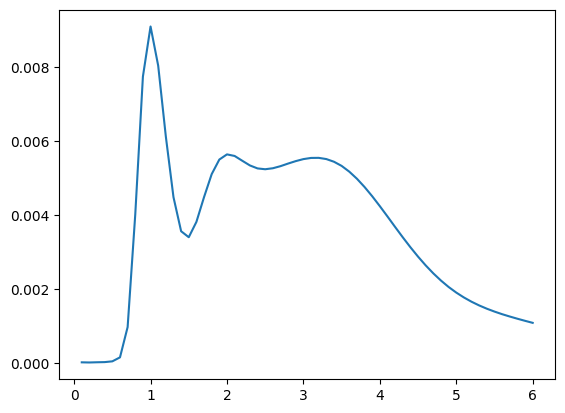

In [16]:
df = pd.DataFrame({'frequencies': frequencies, 'RawFeature': RawFeature})
plt.plot(df['frequencies'],df["RawFeature"])

In [18]:
import pandas as pd
import numpy as np

# 展平 RawFeature 数组
RawFeature_flat = np.ndarray.flatten(RawFeature)

# 创建数据框
df = pd.DataFrame(RawFeature_flat, columns=frequencies)

# 显示数据框
print(df)

ValueError: Shape of passed values is (60, 1), indices imply (60, 60)